In [142]:
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [143]:
data = pd.read_csv('nba-player-stats-2021.csv', encoding='ISO-8859-1')

In [144]:
data = data.rename(columns={'player':'Player', 'pos':'Position', 'age':'Age', 'tm':'Team', 'g':'N_Games', 
                            'gs':'Game_Started', 'mp':'Minute_played', 'fg':'Field_goal', 'fga':'Goal_attempt', 
                            'fgpercent':'Field_goal%',
                            'x3p':'3points_scored', 'x3pa':'3points_Assits', 'x3ppercent':'3points%', 'x2p':'2points_scored', 
                            'x2pa':'2points_assits',
                            'x2ppercent':'2points%', 'ft':'FreeThrow', 'fta':'FreeThrowAttempt',
                            'ftpercent':'FreeThrow%', 'orb':'OffensiveRebound', 'drb':'DenffesiveRebound', 'trb':'TotalRebound', 
                            'ast':'Assists', 'stl':'Steal', 'blk':'Blocks', 'tov':'TurnOver', 'pf':'PersonalFoul',
                            'pts':'Points', 'ortg':'OffensiveRating', 'drtg':'DeffensiveRating'})

### Basic understanding of data

In [145]:
print(data.describe())

              Age     N_Games  Game_Started  Minute_played  Field_goal  \
count  812.000000  812.000000    812.000000     812.000000  812.000000   
mean    26.051724   36.705665     16.672414     825.188424    6.935468   
std      4.059640   25.898042     23.817195     775.786331    3.419585   
min     19.000000    1.000000      0.000000       1.000000    0.000000   
25%     23.000000   12.000000      0.000000     121.000000    5.100000   
50%     25.000000   36.500000      4.000000     577.500000    6.850000   
75%     29.000000   61.000000     25.000000    1414.500000    8.600000   
max     41.000000   82.000000     82.000000    2854.000000   49.000000   

       Goal_attempt  Field_goal%  3points_scored  3points_Assits    3points%  \
count    812.000000   797.000000      812.000000      812.000000  740.000000   
mean      16.066995     0.434257        2.028695        6.467611    0.303445   
std        5.627889     0.137794        1.573494        4.443072    0.138111   
min        0.

In [146]:
print(f'Duplicate entries: {data.duplicated().sum()} \nNull values: \n{data.isna().sum()}')

Duplicate entries: 0 
Null values: 
Player                0
Position              0
Age                   0
Team                  0
N_Games               0
Game_Started          0
Minute_played         0
Field_goal            0
Goal_attempt          0
Field_goal%          15
3points_scored        0
3points_Assits        0
3points%             72
2points_scored        0
2points_assits        0
2points%             28
FreeThrow             0
FreeThrowAttempt      0
FreeThrow%           97
OffensiveRebound      0
DenffesiveRebound     0
TotalRebound          0
Assists               0
Steal                 0
Blocks                0
TurnOver              0
PersonalFoul          0
Points                0
OffensiveRating      10
DeffensiveRating      0
dtype: int64


In [147]:
data.shape

(812, 30)

In [148]:
# Fill all missing data with the most frequent rather than droping them since this is a small dataset
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

## Exploratory Data Analysis (EDA)

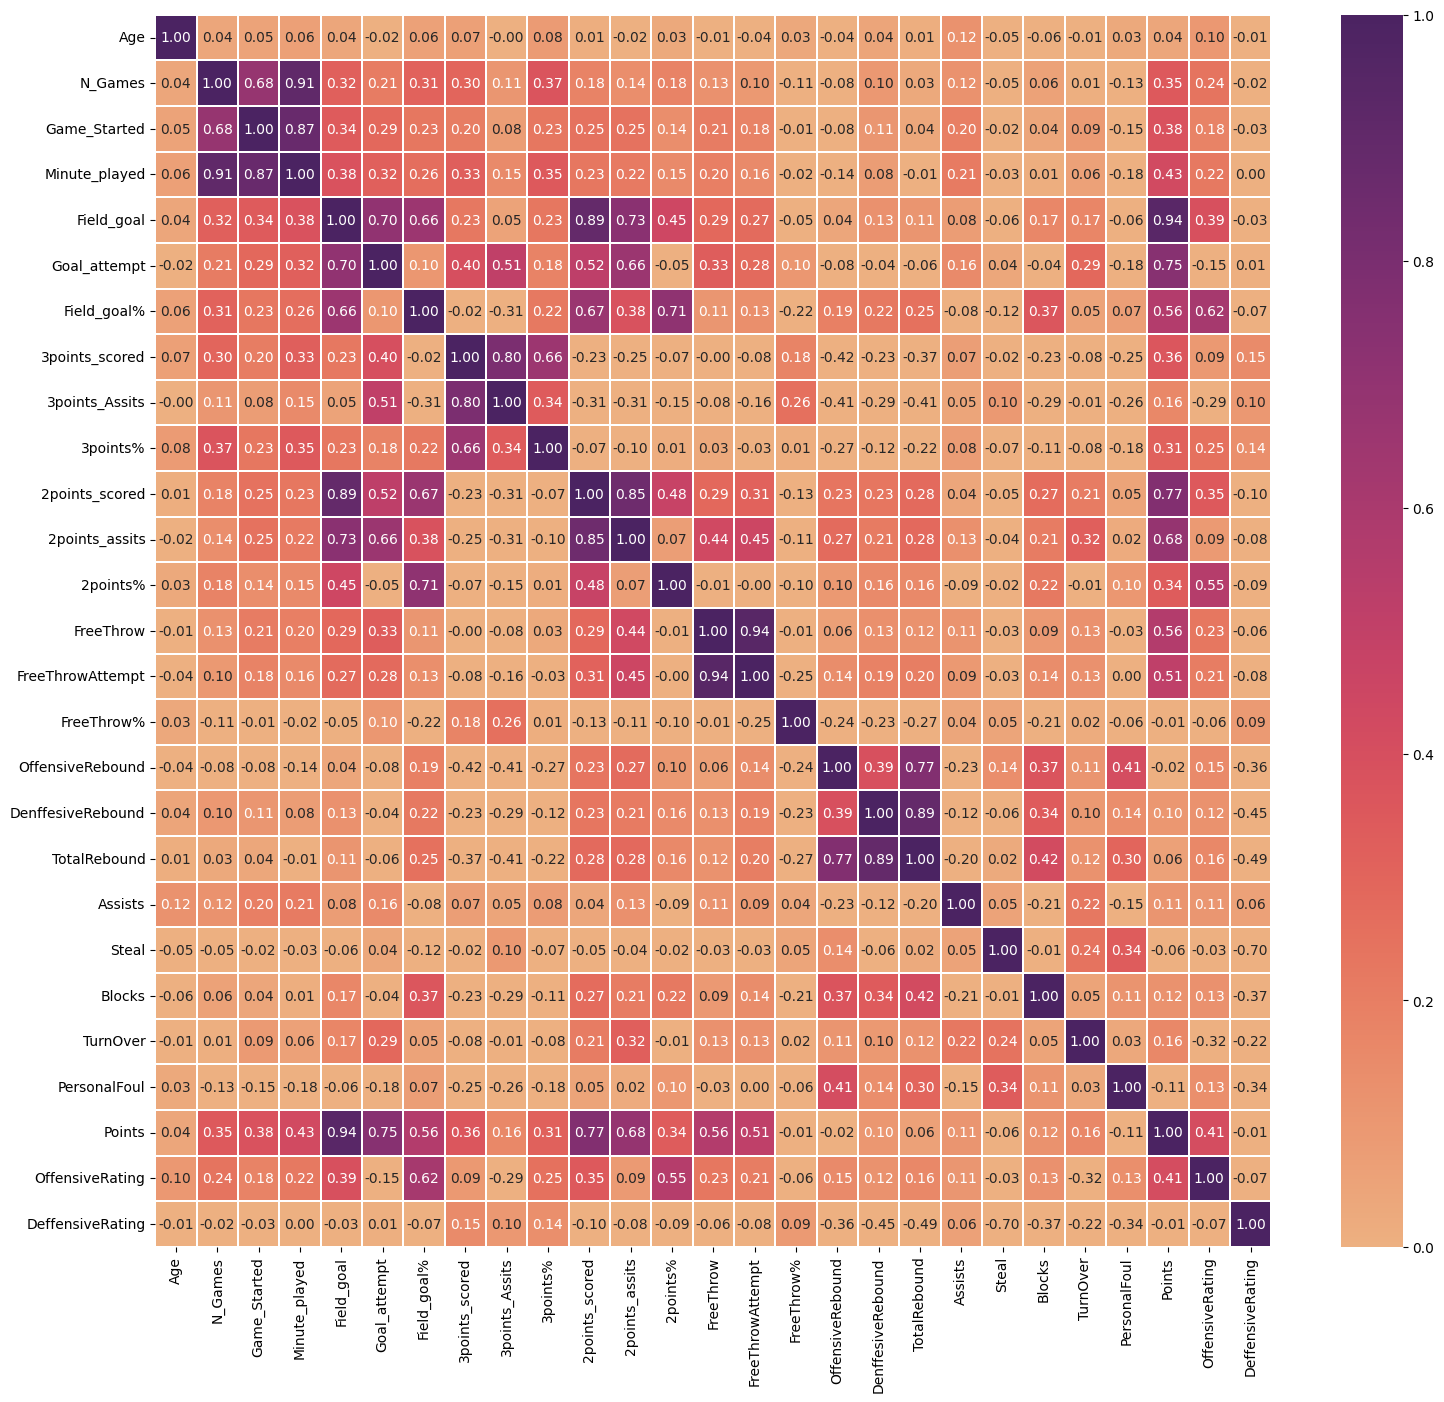

In [149]:
# Create a heatmap to see how our feature are interacting with one another

plt.figure(figsize=(18,16))
corr = data.drop(columns=['Player', 'Position', 'Team']).corr(method='pearson')
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=1,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

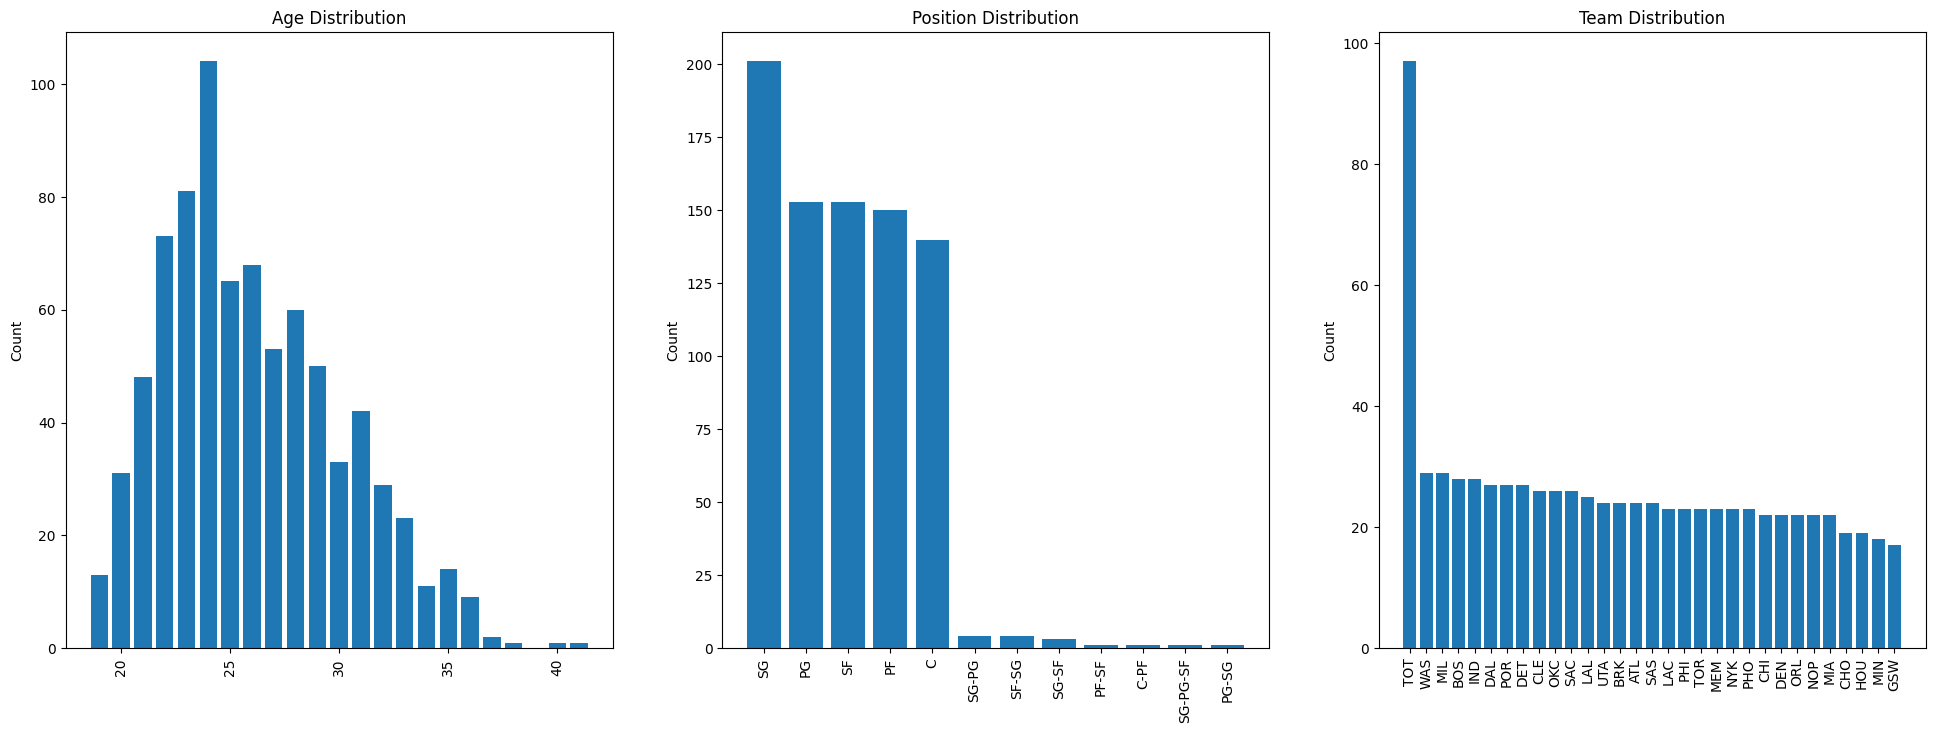

In [150]:
# Create a figure and subplots to plot all categorical variable distribution
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
variables = ['Age', 'Position', 'Team']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var.capitalize()} Distribution')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)

## Feature Engineering

In [151]:
# Create new features Age_Binned to group age into categories and average Offensive/Defensive rating.
data['Age_Binned'] = pd.cut(data['Age'], 5, labels=[20, 25, 30, 35, 40])
data['Avg_Rating'] = (data['OffensiveRating'] + data['DeffensiveRating'])/2
data['Avg_Rebound'] = (data['OffensiveRebound'] + data['DenffesiveRebound'])/2

# Drop features that are not relevent to our study
# 'OffensiveRating', 'DeffensiveRating'
data = data.drop(columns=['Team', 'OffensiveRating', 'DeffensiveRating', 'DenffesiveRebound', 'OffensiveRebound'])

##### Identify and Remove outliers

/var/folders/sb/73j4d15s4k34y66s1tpvsgx80000gn/T/ipykernel_528/2674980487.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


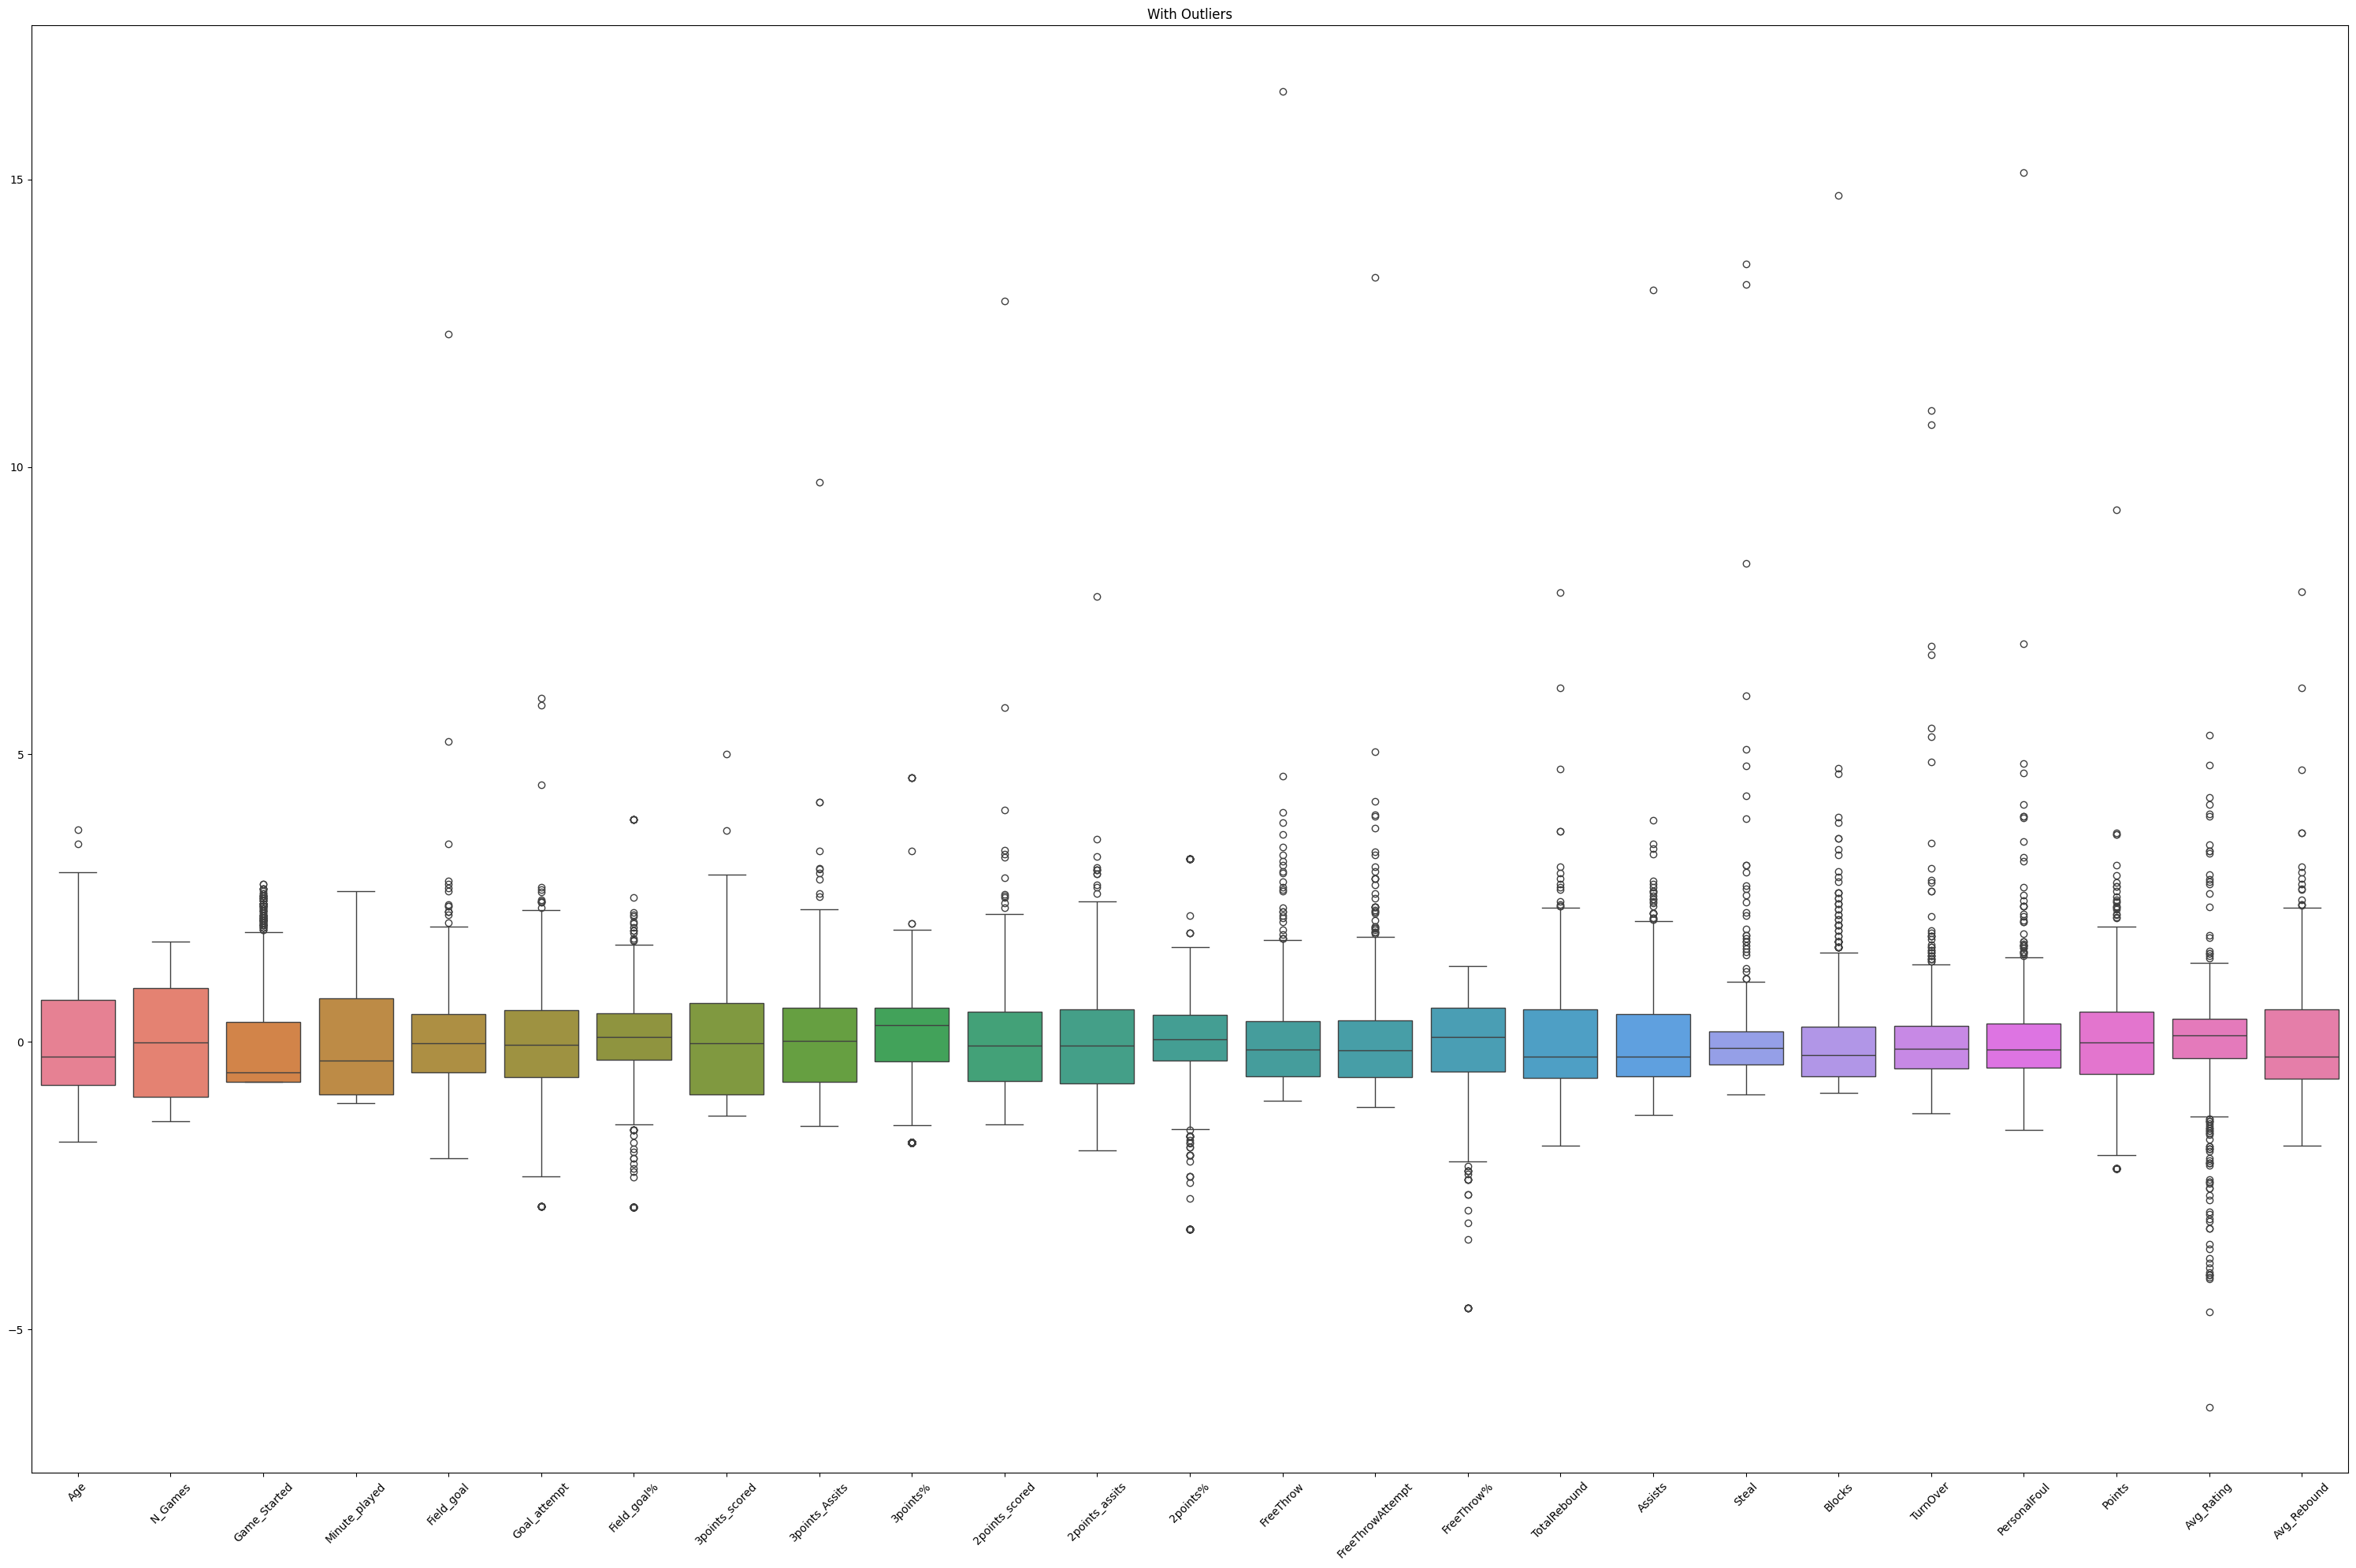

In [152]:
features = [col for col in data.columns if col not in ['Position', 'Player','Age_Binned']]
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('With Outliers')
plt.tight_layout()
plt.show()

/var/folders/sb/73j4d15s4k34y66s1tpvsgx80000gn/T/ipykernel_528/3904851345.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


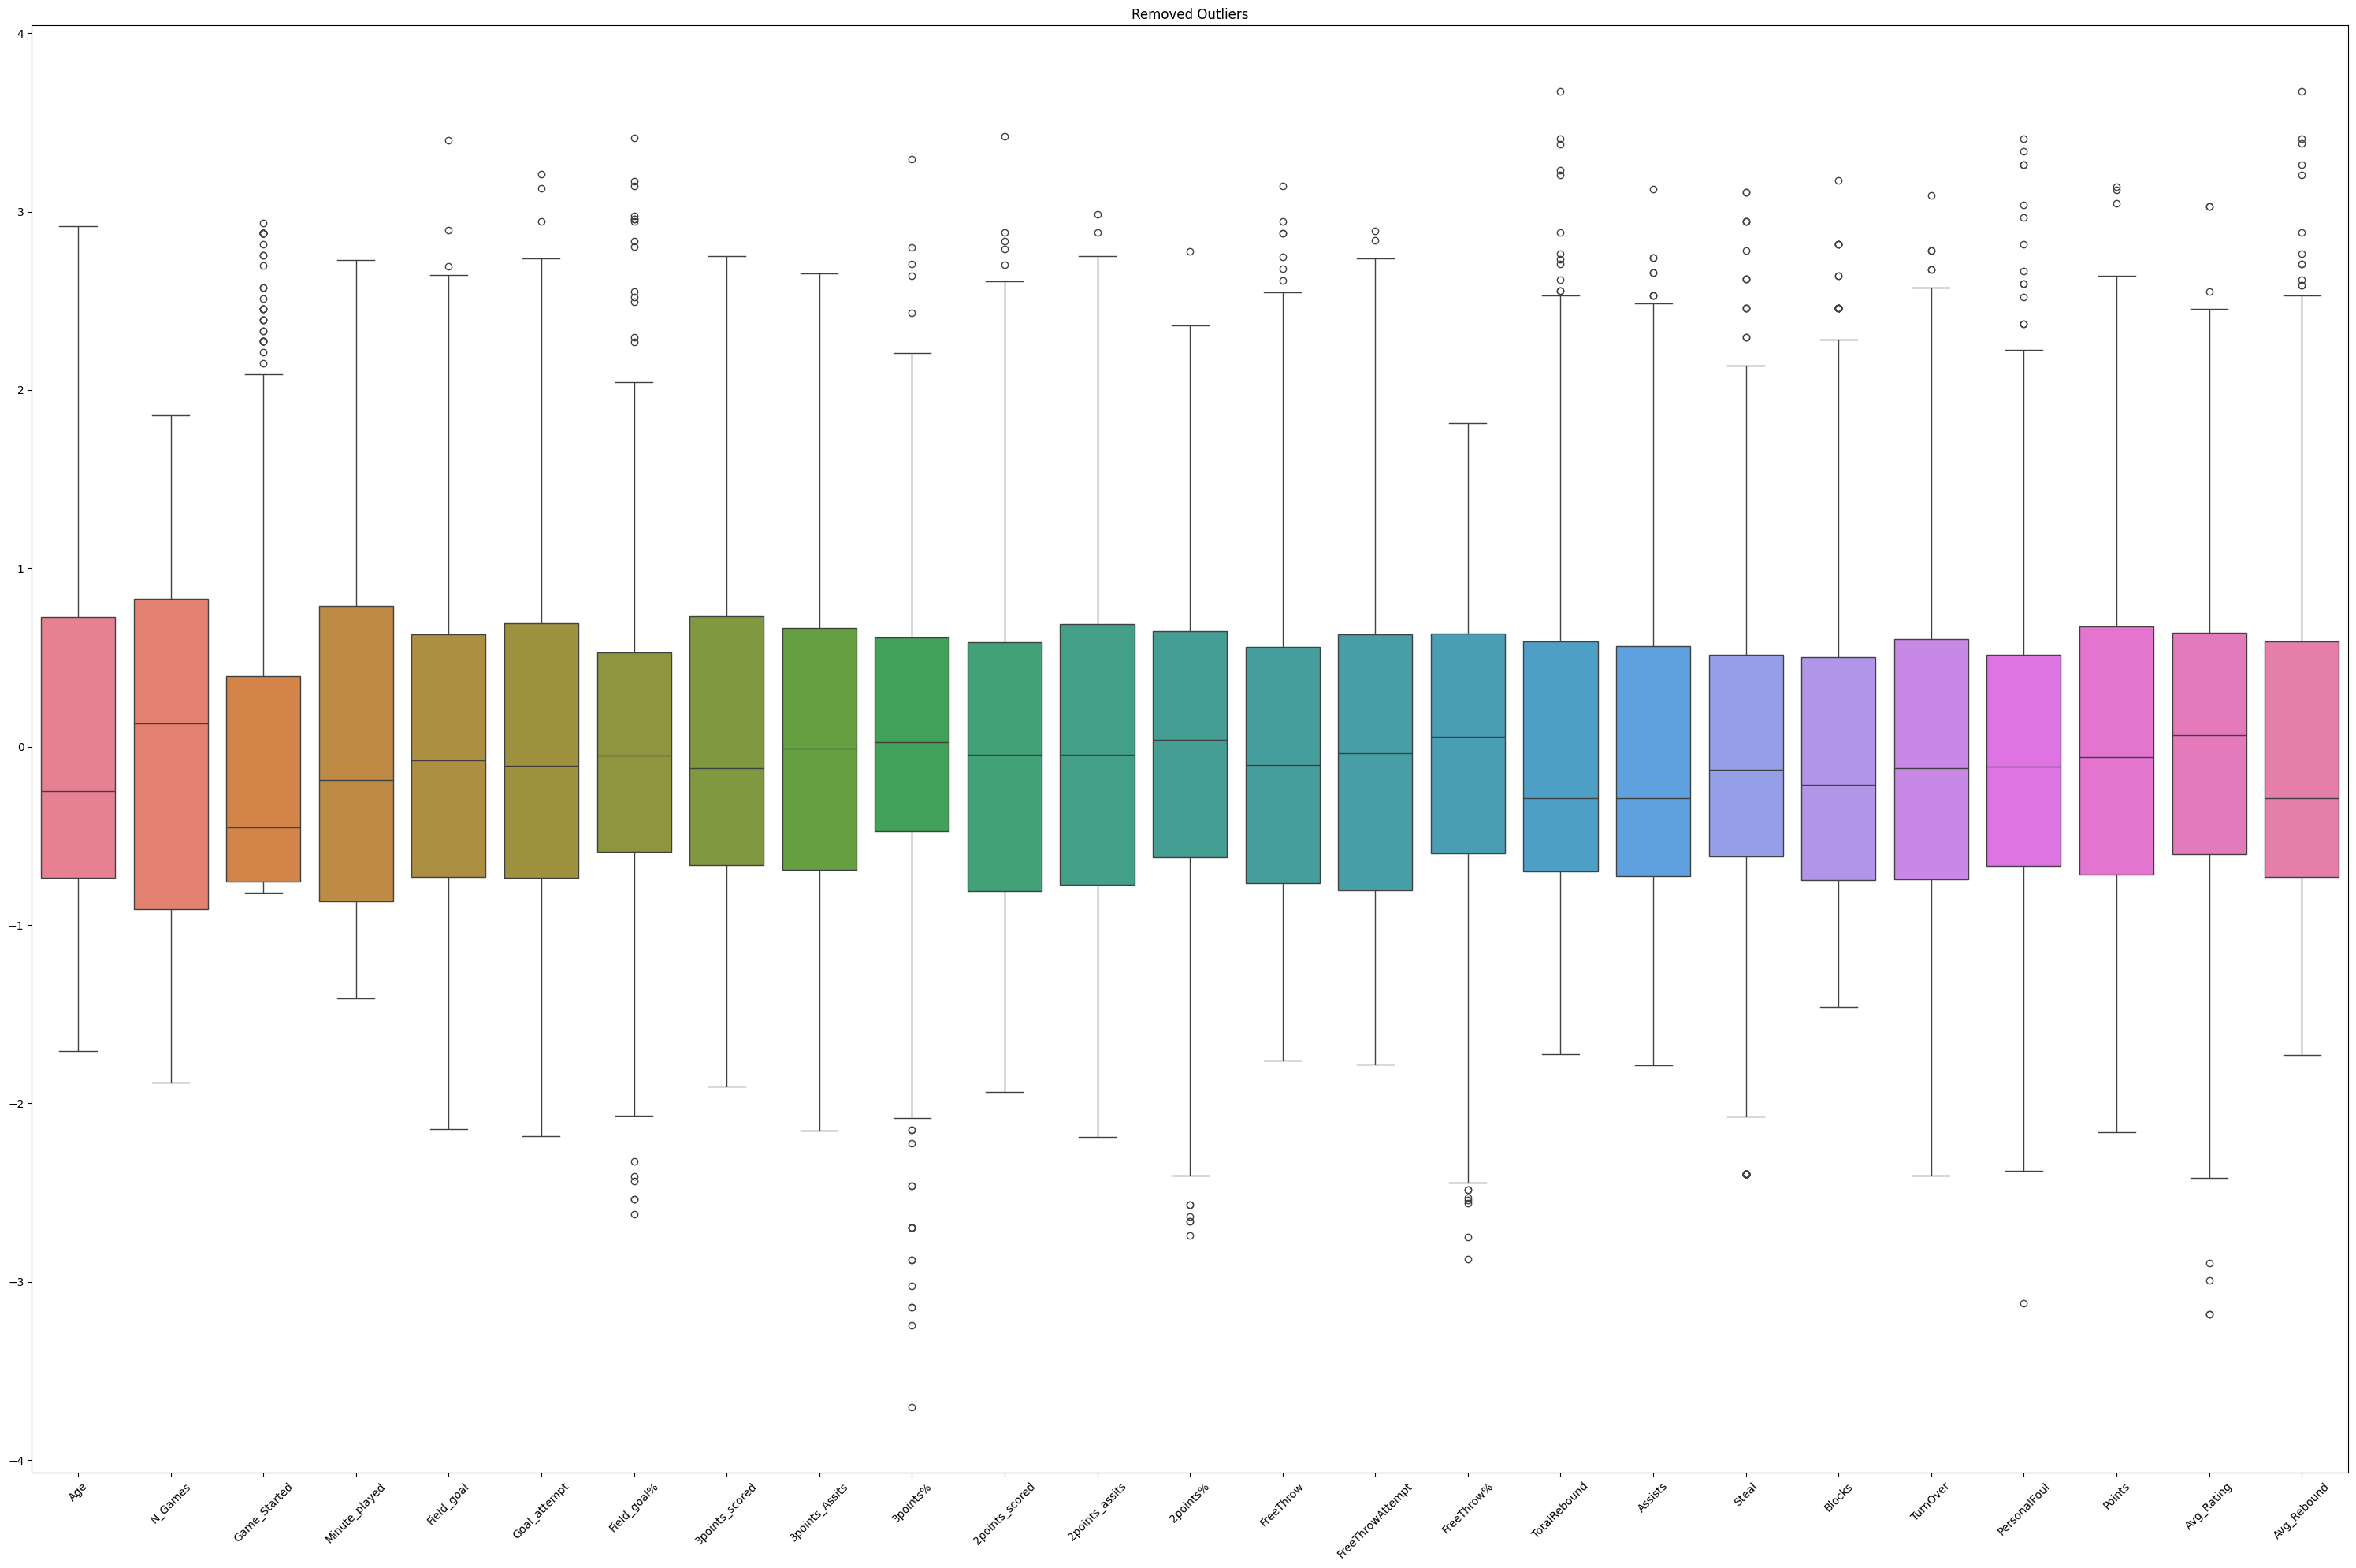

In [153]:
Q1 = scaled_data.quantile(0.25)
Q3 = scaled_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = ~((scaled_data < lower_bound) | (scaled_data > upper_bound)).any(axis=1)
filtered_data = data[mask].copy()

filtered_scaled_data = pd.DataFrame(scaler.fit_transform(filtered_data[features]), columns=features, index=filtered_data.index)

fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=filtered_scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Removed Outliers')
plt.tight_layout()
plt.show()

### Principal Component Analysis (PCA)

In [154]:
pca = PCA(n_components=10, random_state=42)  
pca_components = pca.fit_transform(filtered_scaled_data)

labels = [f'PC{i+1}' for i in range(pca.n_components_)]

pca_df = pd.DataFrame(pca_components, columns=labels)

pca_merged = pd.concat([filtered_data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

top_players = pca_merged.sort_values(by='PC1', ascending=False).head(15)
bottom_players = pca_merged.sort_values(by='PC1', ascending=True).head(15)

#pca_loadings = pd.DataFrame(pca.components_.T, columns=labels, index=features)

top_features = top_players[features]
bottom_features = bottom_players[features]

mean_top_features = top_features.mean()
mean_bottom_features = bottom_features.mean()

feature_comparison = pd.DataFrame({
    'Top Performers': mean_top_features,
    'Bottom Performers': mean_bottom_features
})

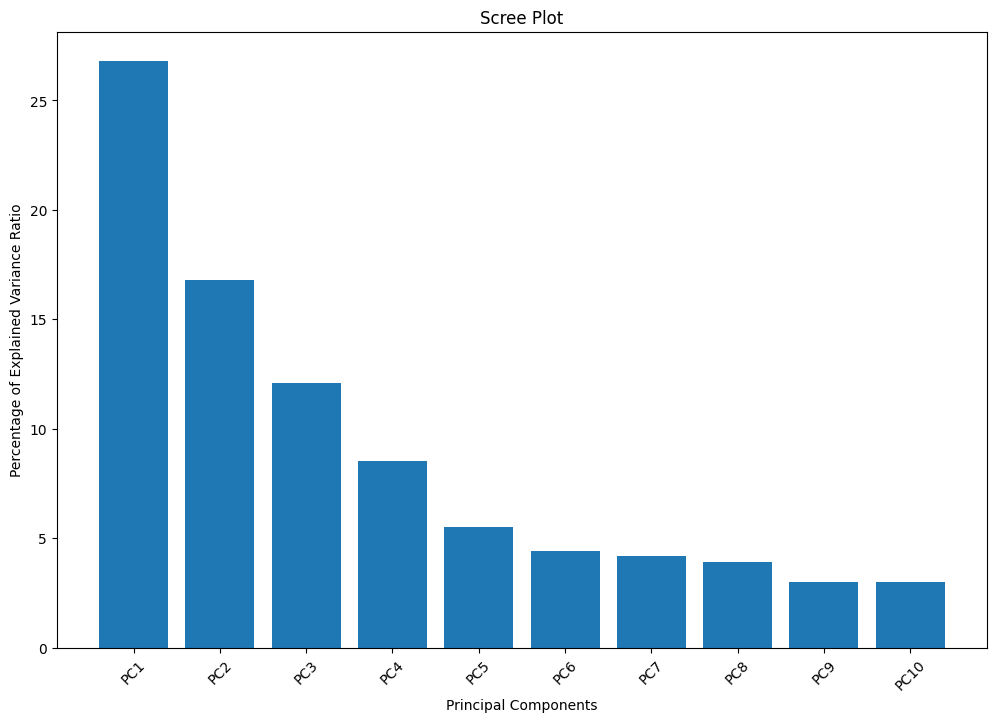

In [155]:
exp_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.figure(figsize=(12,8))
plt.bar(range(1, len(exp_var)+1), height=exp_var, tick_label=labels)

plt.ylabel('Percentage of Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.xticks(rotation=45)
plt.show()

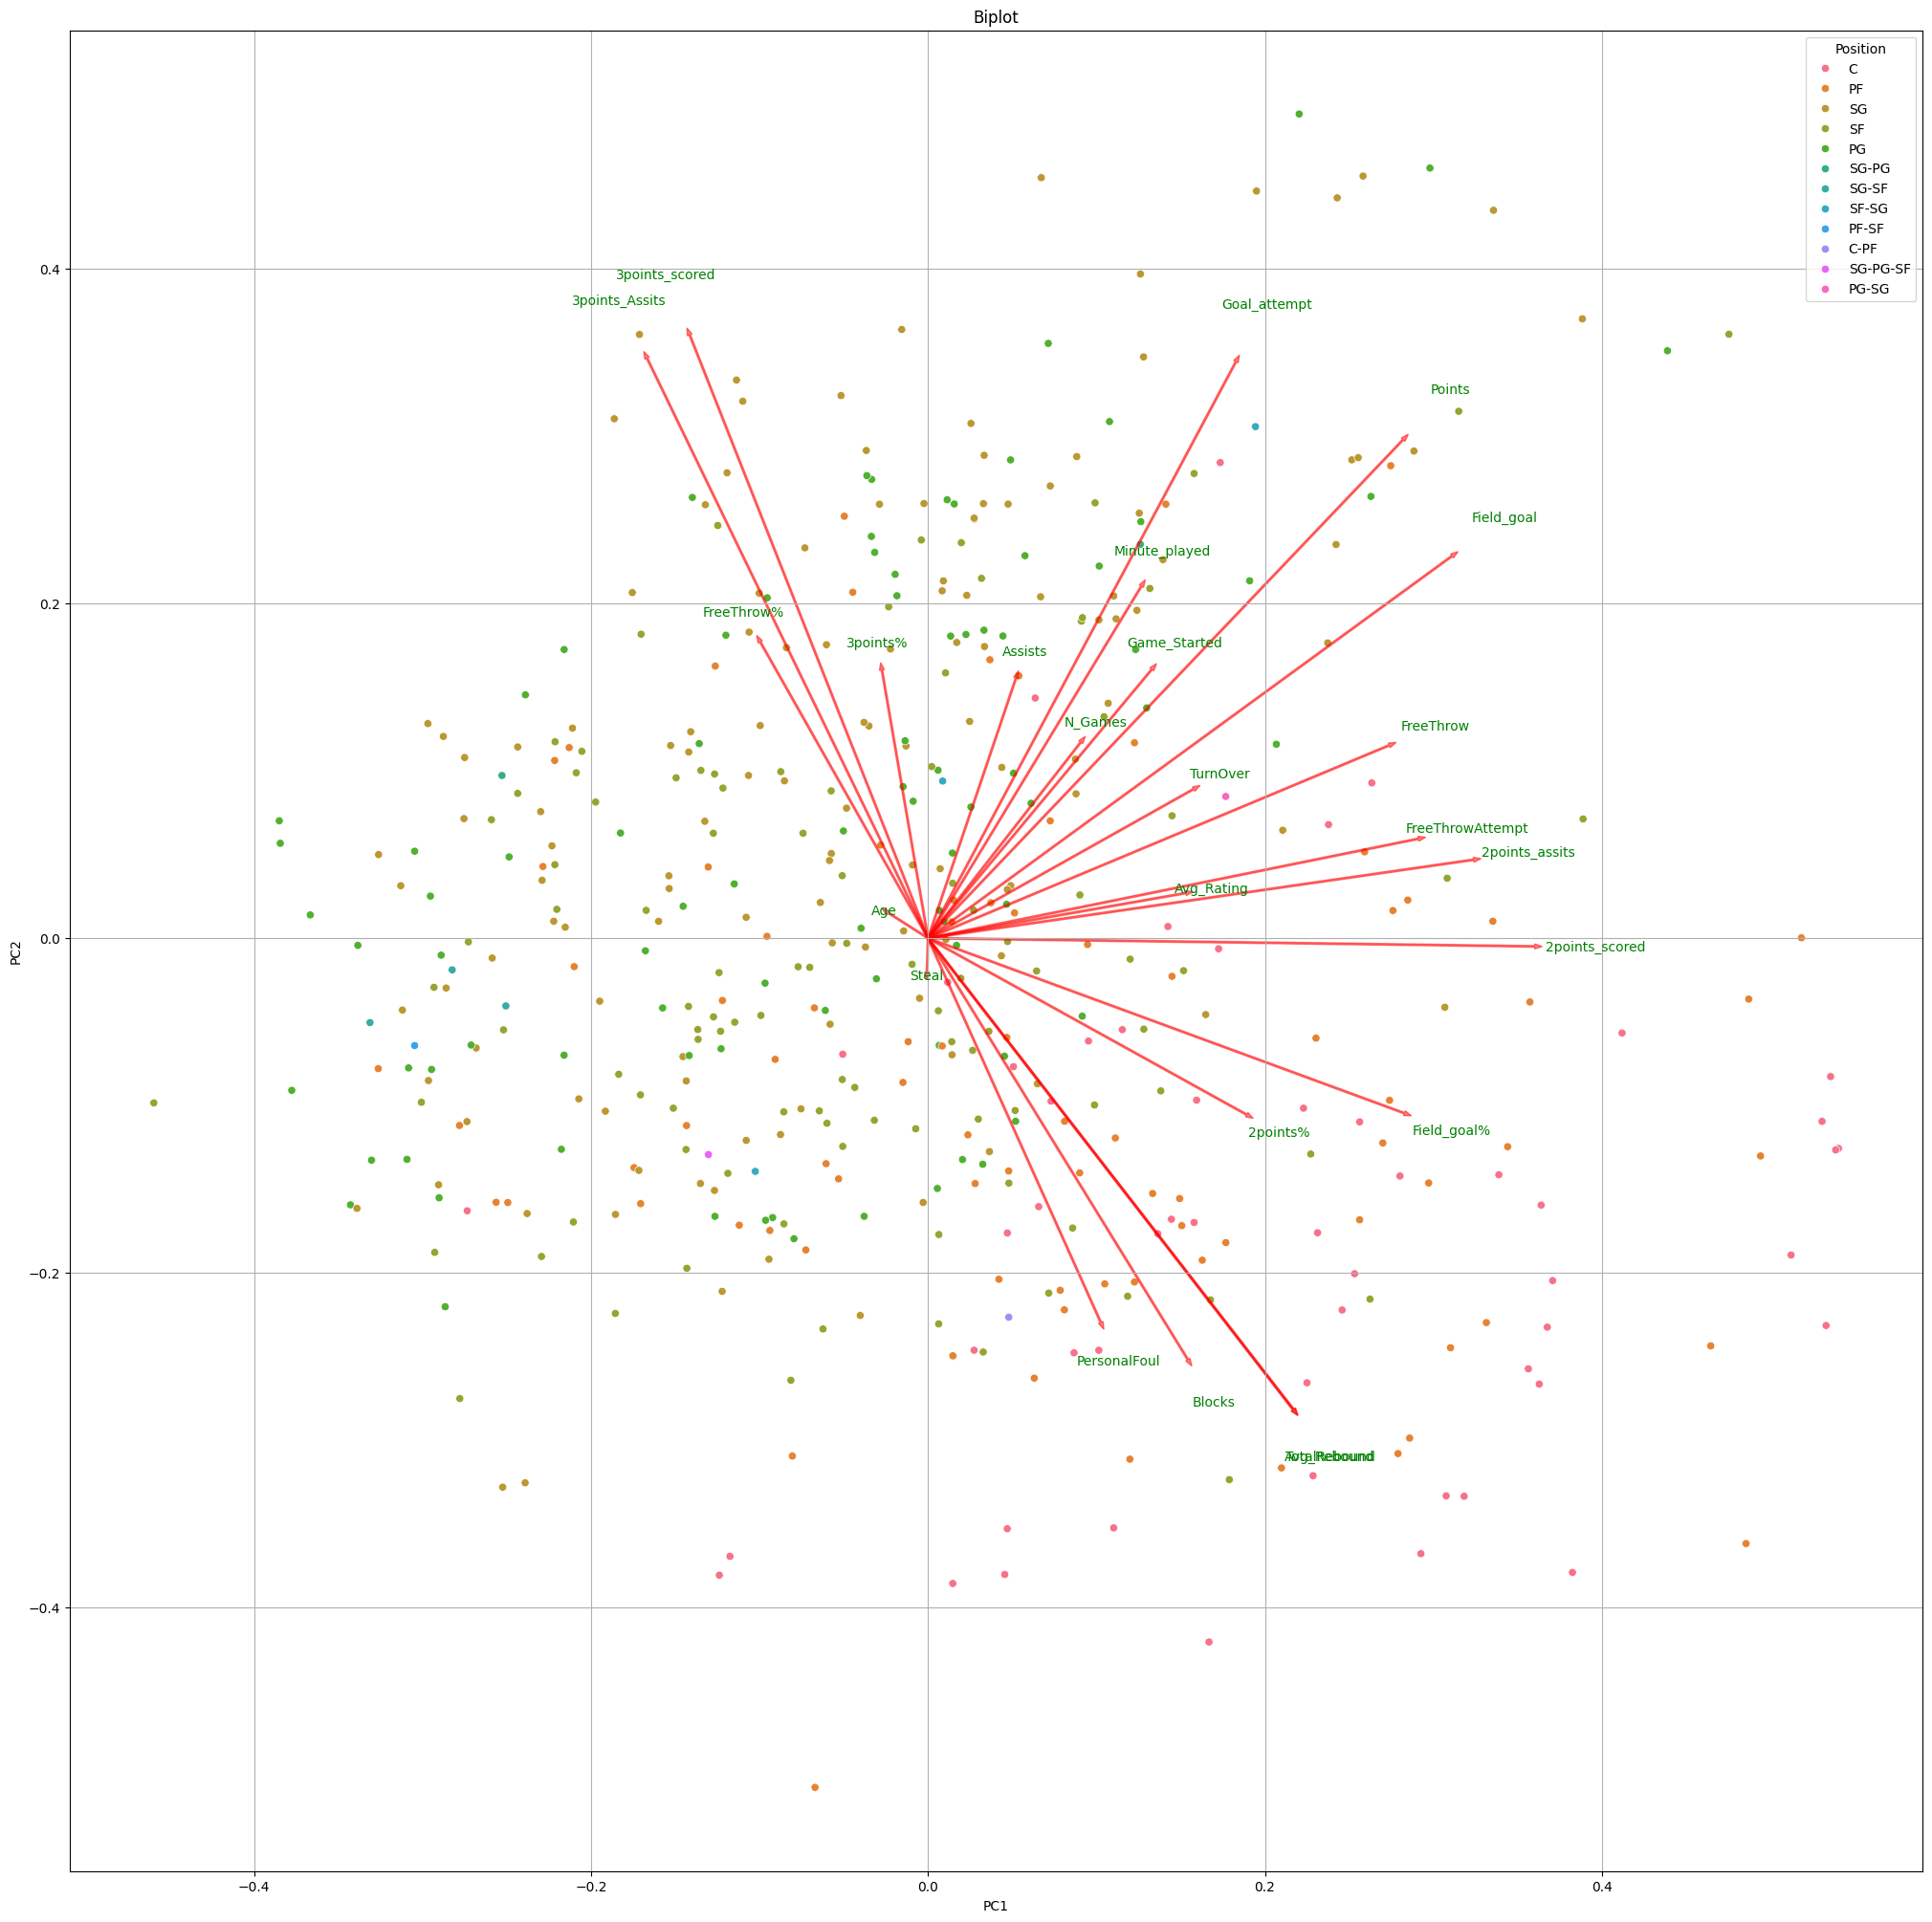

In [156]:
y = pca_merged['Position']

def myplot(score, coeff, labels, y):

    pc1 = score['PC1']
    pc2 = score['PC2']
    n = coeff.shape[0]
    # Scale the x and y to make the loadings easier to see
    scalex = 1/(pc1.max() - pc1.min())
    scaley = 1/(pc2.max() - pc2.min())
    plt.figure(figsize=(25,25))
    sns.scatterplot(x=pc1 * scalex, y=pc2 * scaley, hue=y)
    for i in range(n):
        # Plot an arrow for each component weight
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        # Plot the name of the component (use 1.15 to plot the text slightly above the arrow)
        plt.text(coeff[i, 0] * 1.1, coeff[i, 1] * 1.1,
                 labels[i], color='g', ha='center', va='center')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title('Biplot')
    plt.grid()
    
    plt.show()
# Call the function. Use only the 2 PCs. 
myplot(pca_df, np.transpose(pca.components_), features, y)

#### Feature importance for classification

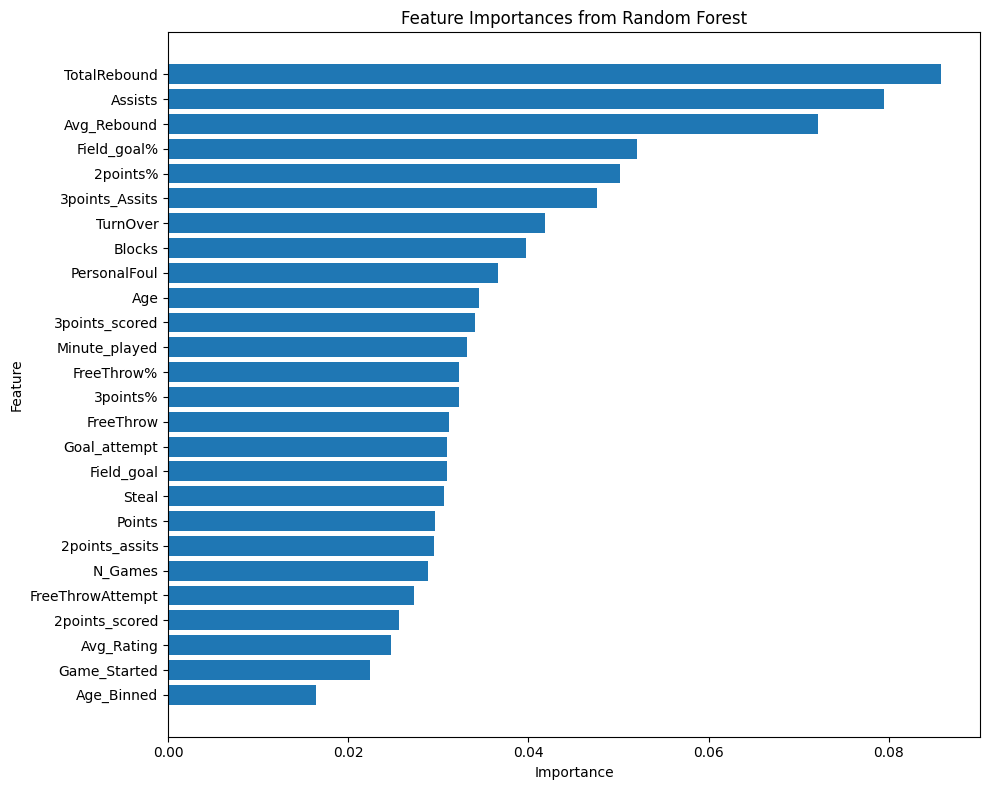

In [157]:
X = filtered_data.drop(columns=['Position', 'Player'])
y = pca_merged['Position']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importances['Feature'], importances['Importance'] )
plt.title("Feature Importances from Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# More Feature Engineering

In [ ]:
data['3pts_assist_to_score_ratio'] = data['3points_Assits']/data['3points_scored']

'''data['Block_to_Foul_Ratio'] = data['Blocks']/data['PersonalFoul']
data['Steal_to_Turnover_Ratio'] = data['Steal']/data['TurnOver']'''

In [129]:
f = importances['Feature'].head(10).values
f

array(['TotalRebound', 'Assists', 'Avg_Rebound', 'Field_goal%',
       '2points%', '3points_Assits', 'TurnOver', 'Blocks', 'PersonalFoul',
       'Age'], dtype=object)

## Model Training, Test and Evaluation

In [130]:
features = ['TotalRebound', 'Assists', 'Avg_Rebound', 'Field_goal%',
       '2points%', '3points_Assits', 'TurnOver', 'Blocks', 'PersonalFoul',
       'Age']

class_count = y.value_counts()
rare_class = [cls for cls, count in class_count.items() if count <=4]
new_class_indice = [i for i, label in enumerate(y) if label not in rare_class]

X = filtered_data[features]
y = filtered_data['Position']

X_cleaned = X.iloc[new_class_indice]
y_cleaned = y.iloc[new_class_indice]

Classifier: SVC
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Score: 0.7066666666666667
Best Parameters: {'C': 200, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           C       0.80      0.67      0.73        12
          PF       0.56      0.62      0.59        16
          PG       0.65      0.65      0.65        17
          SF       0.61      0.67      0.64        21
          SG       0.58      0.54      0.56        26

    accuracy                           0.62        92
   macro avg       0.64      0.63      0.63        92
weighted avg       0.62      0.62      0.62        92

---------------------------------------------------------------------------
Classifier: RandomForestClassifier
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best Score: 0.7295238095238096
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 600}
  

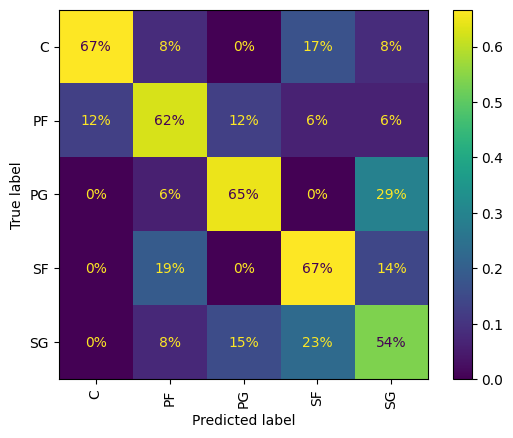

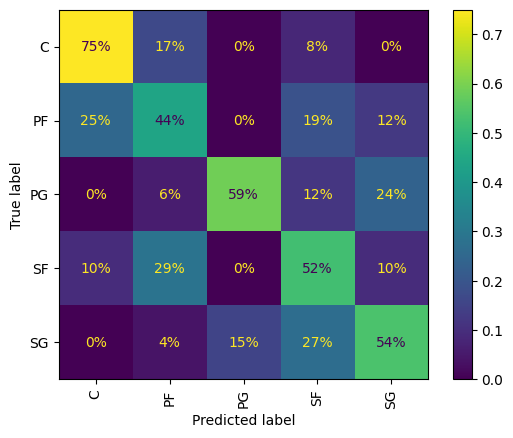

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

classifiers = {
    'SVC': SVC(class_weight='balanced', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced',random_state=42),
}

params = {
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [1, 2, 3, 4, 5, 6],
        'C': [1, 10, 100, 200, 500],
        'gamma': [0.1, 0.01, 0.001]
    },
    'RandomForestClassifier': {
        'n_estimators': [1, 10, 100, 200, 500, 600],
        'max_depth': [100, 200, 300, 400, 500],
        'bootstrap': [True],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy']
    }
}

stratified_kfold = StratifiedKFold(n_splits=3)

for name, clf in classifiers.items():
    print(f'Classifier: {name}')

    grid_best_model = GridSearchCV(estimator=clf, param_grid=params[name], scoring='f1_micro', n_jobs=-1, 
                                   cv=stratified_kfold, verbose=1)
    
    grid_best_model.fit(X_train_smote, y_train_smote)

    y_pred = grid_best_model.predict(X_test_scaled)

    print(f'Best Score: {grid_best_model.best_score_}')

    print(f'Best Parameters: {grid_best_model.best_params_}')

    print(ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical'))
    
    print(classification_report(y_test, y_pred))

    print('-' * 75)

              precision    recall  f1-score   support

           C       0.80      0.67      0.73        12
          PF       0.56      0.62      0.59        16
          PG       0.65      0.65      0.65        17
          SF       0.61      0.67      0.64        21
          SG       0.58      0.54      0.56        26

    accuracy                           0.62        92
   macro avg       0.64      0.63      0.63        92
weighted avg       0.62      0.62      0.62        92



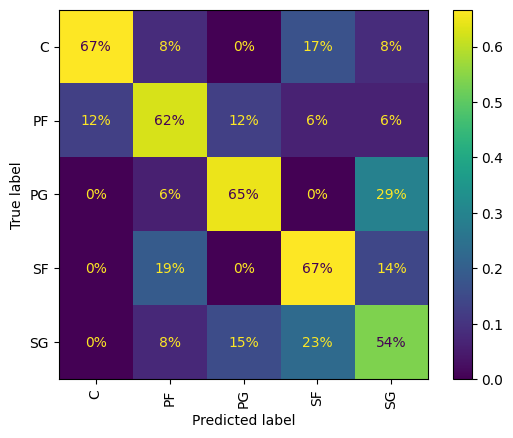

In [207]:
svc_final = SVC(C= 200, degree=1, gamma= .1, kernel= 'rbf')

svc_final.fit(X_train_smote, y_train_smote)

y_pred = svc_final.predict(X_test_scaled)
metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.55      0.60      0.57        10
          PF       0.25      0.33      0.29        12
          PG       0.88      0.70      0.78        10
          SF       0.47      0.50      0.49        18
          SG       0.73      0.58      0.65        19

    accuracy                           0.54        69
   macro avg       0.58      0.54      0.55        69
weighted avg       0.57      0.54      0.55        69



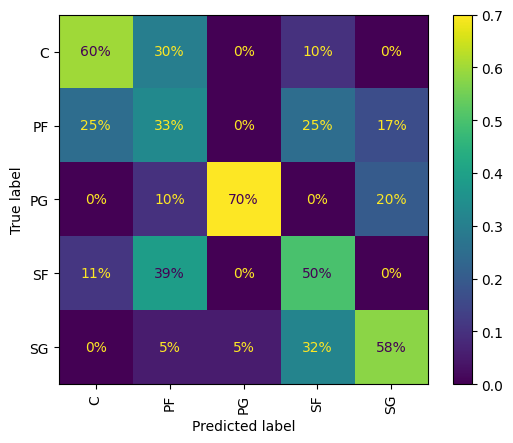

In [137]:
rf_model = RandomForestClassifier(bootstrap=True, criterion= 'entropy', max_depth= 300, max_features= 'sqrt', n_estimators= 600)
rf_model.fit(X_train_smote, y_train_smote)

#'bootstrap': True, 'criterion': 'entropy', 'max_depth': 400, 'max_features': 'log2', 'n_estimators': 500

y_pred = rf_model.predict(X_test_scaled)
metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical')

print(classification_report(y_test, y_pred))

# Sample test sets